In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_parquet("cmm_erdos_bootcamp_2020_timeseries.pq")

In [3]:
df.head()

,date_val,calendar_year,calendar_month,calendar_day,day_of_week,is_weekday,is_workday,is_holiday,volume_A,volume_B,volume_C
0,2017-01-01,2017,1,1,1,0,0,1,974,701,574
1,2017-01-02,2017,1,2,2,1,0,0,5073,2976,3149
2,2017-01-03,2017,1,3,3,1,1,0,6710,4249,3595
3,2017-01-04,2017,1,4,4,1,1,0,5746,3942,3651
4,2017-01-05,2017,1,5,5,1,1,0,5863,4279,3792


In [4]:
df_train = df.copy().loc[df.calendar_year < 2019]
df_test = df.copy().drop(df_train.index)

In [5]:
def make_lag_df(df,feature,lag):
    lag_df = df.copy()
    lag_df[feature + '_lag'] = np.nan
    
    lag_df.loc[lag:,feature + '_lag'] = lag_df.loc[0:len(lag_df)-(lag+1),feature].values
    return lag_df

In [6]:
def get_autocorr(df,feature,lag):
    df = make_lag_df(df,feature,lag)
    mean_y = df[feature].mean()
    
    y_ts = df[feature].values
    y_lags = df.dropna()[feature + '_lag'].values
    
    numerator = np.sum((y_ts[lag:] - mean_y)*(y_lags - mean_y))
    denom = np.sum(np.power(y_ts - mean_y,2))
    
    return numerator/denom

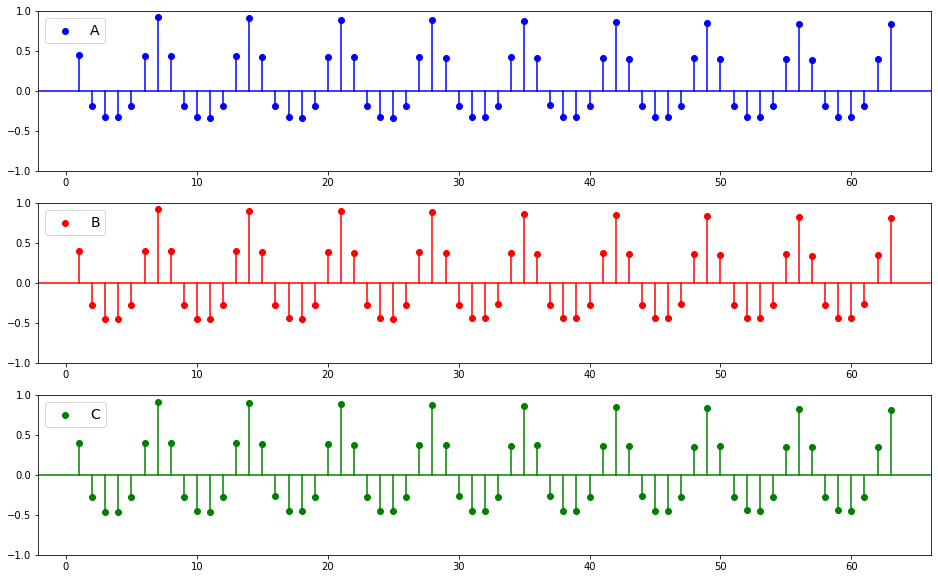

In [7]:
max_lag = 63

# ACF Plot
fig,ax = plt.subplots(3,1,figsize = (16,10),sharey=True)

plt.ylim(-1,1)

ax[0].axhline(y=0, xmin=0, xmax=20, color = "blue")
ax[1].axhline(y=0, xmin=0, xmax=20, color = "red")
ax[2].axhline(y=0, xmin=0, xmax=20, color = "green")

ax[0].scatter(np.arange(1,max_lag+1,1), 
           [get_autocorr(df_train,'volume_A',lag) for lag in np.arange(1,max_lag+1,1)],
           c='b',label='A')
ax[1].scatter(np.arange(1,max_lag+1,1), 
           [get_autocorr(df_train,'volume_B',lag) for lag in np.arange(1,max_lag+1,1)],
           c='r',label='B')
ax[2].scatter(np.arange(1,max_lag+1,1), 
           [get_autocorr(df_train,'volume_C',lag) for lag in np.arange(1,max_lag+1,1)],
           c='g',label='C')

for i in np.arange(1,max_lag + 1,1):
    ax[0].plot(i*np.ones(2),[0,get_autocorr(df_train,'volume_A',i)],'b')
    ax[1].plot(i*np.ones(2),[0,get_autocorr(df_train,'volume_B',i)],'r')
    ax[2].plot(i*np.ones(2),[0,get_autocorr(df_train,'volume_C',i)],'g')

ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)

plt.show()

In [20]:
df_new_train = pd.DataFrame()
df_new_train['first_A'] = df_train['volume_A'] - df_train['volume_A'].shift(1)
df_new_train['first_B'] = df_train['volume_B'] - df_train['volume_B'].shift(1)
df_new_train['first_C'] = df_train['volume_C'] - df_train['volume_C'].shift(1)

In [21]:
df_new_train = df_new_train.drop([0])
df_new_train = df_new_train.reset_index(drop=True)

In [22]:
df_new_train.head()

,first_A,first_B,first_C
0,4099.0,2275.0,2575.0
1,1637.0,1273.0,446.0
2,-964.0,-307.0,56.0
3,117.0,337.0,141.0
4,-277.0,-323.0,-262.0


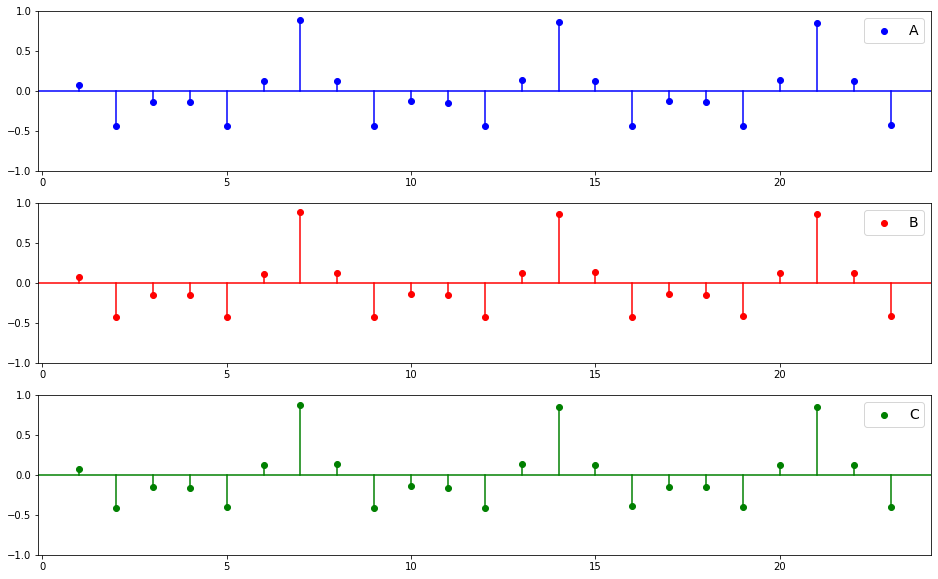

In [23]:
max_lag = 23

# ACF Plot
fig,ax = plt.subplots(3,1,figsize = (16,10),sharey=True)

plt.ylim(-1,1)

ax[0].axhline(y=0, xmin=0, xmax=20, color = "blue")
ax[1].axhline(y=0, xmin=0, xmax=20, color = "red")
ax[2].axhline(y=0, xmin=0, xmax=20, color = "green")

ax[0].scatter(np.arange(1,max_lag+1,1), 
           [get_autocorr(df_new_train,'first_A',lag) for lag in np.arange(1,max_lag+1,1)],
           c='b',label='A')
ax[1].scatter(np.arange(1,max_lag+1,1), 
           [get_autocorr(df_new_train,'first_B',lag) for lag in np.arange(1,max_lag+1,1)],
           c='r',label='B')
ax[2].scatter(np.arange(1,max_lag+1,1), 
           [get_autocorr(df_new_train,'first_C',lag) for lag in np.arange(1,max_lag+1,1)],
           c='g',label='C')

for i in np.arange(1,max_lag + 1,1):
    ax[0].plot(i*np.ones(2),[0,get_autocorr(df_new_train,'first_A',i)],'b')
    ax[1].plot(i*np.ones(2),[0,get_autocorr(df_new_train,'first_B',i)],'r')
    ax[2].plot(i*np.ones(2),[0,get_autocorr(df_new_train,'first_C',i)],'g')

ax[0].legend(fontsize=14)
ax[1].legend(fontsize=14)
ax[2].legend(fontsize=14)

plt.show()

In [28]:
import statsmodels

In [30]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [32]:
from statsmodels.tsa.stattools import acf, pacf

In [37]:
lag_acf = acf(df_train['volume_A'])
lag_pacf = pacf(df_train['volume_A'] )

/Users/vasudha/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


/Users/vasudha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

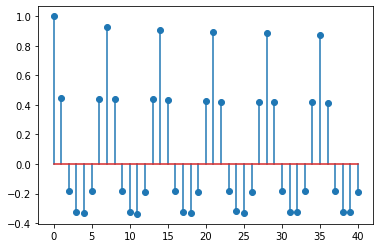

In [38]:
plt.stem(lag_acf)

/Users/vasudha/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.
  """Entry point for launching an IPython kernel.


<StemContainer object of 3 artists>

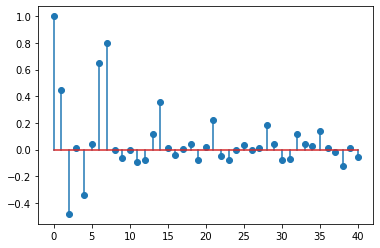

In [39]:
plt.stem(lag_pacf)

In [42]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

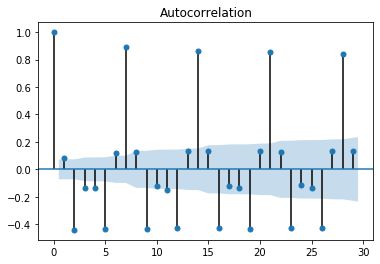

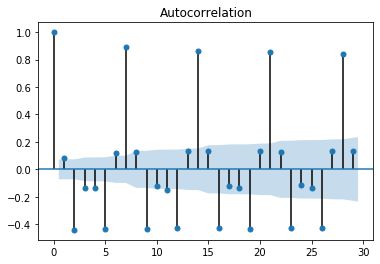

In [45]:
plot_acf(df_new_train['first_A'])

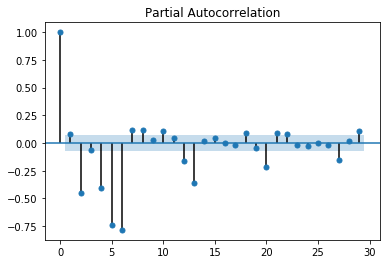

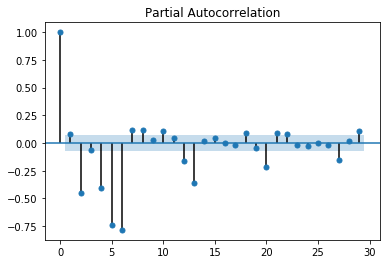

In [46]:
plot_pacf(df_new_train['first_A'])

In [49]:
model = SARIMAX(df_train['volume_A'], order=(2,1,2),seasonal_order=(1,1,0,7),enforce_stationarity=False)

In [50]:
model_fit = model.fit()

In [64]:
forecast = model_fit.forecast(365)
forecast.iloc[[1]]

731    8391.180339
dtype: float64

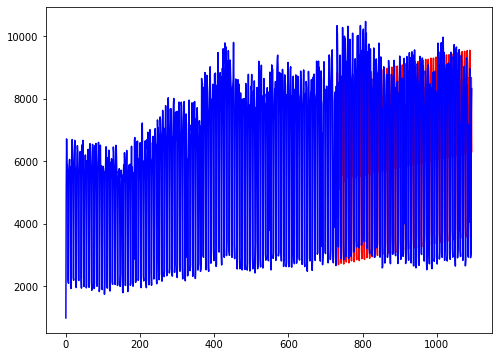

In [66]:
plt.figure(figsize=[8,6])
plt.plot(forecast,'r')
plt.plot(df['volume_A'],'b')
plt.show()

In [60]:
diff = forecast - df_train['volume_A'] 
diff

0      NaN
1      NaN
2      NaN
3      NaN
4      NaN
        ..
1090   NaN
1091   NaN
1092   NaN
1093   NaN
1094   NaN
Length: 1095, dtype: float64

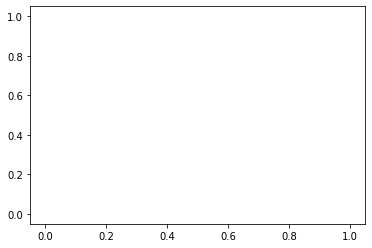

In [59]:
plt.plot(diff)